In [61]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
def read_npy(paths,sep=2):
    npys = []
    for i,path in enumerate(paths):
        npys.append(np.load(path))
        if i % sep == 0:
            print(f'{i}:Loading {path} {npys[-1].shape}')
    print(f'Total of {len(npys)} files loaded')
    return npys

In [5]:
!ls ~/ceph/mldust-ver2/data/npy/TurbPar.out2.00100.hdf5-*.npy

/mnt/home/tchan1/ceph/mldust-ver2/data/npy/TurbPar.out2.00100.hdf5-rho.npy
/mnt/home/tchan1/ceph/mldust-ver2/data/npy/TurbPar.out2.00100.hdf5-rhop.npy
/mnt/home/tchan1/ceph/mldust-ver2/data/npy/TurbPar.out2.00100.hdf5-vel.npy
/mnt/home/tchan1/ceph/mldust-ver2/data/npy/TurbPar.out2.00100.hdf5-vp.npy
/mnt/home/tchan1/ceph/mldust-ver2/data/npy/TurbPar.out2.00100.hdf5-vrel.npy


In [68]:
tgt_rhop,unetr_rhop,unetv_rhop = read_npy(
    ['/mnt/home/tchan1/ceph/mldust-ver2/data/npy/TurbPar.out2.00100.hdf5-rhop.npy',
     '/mnt/home/tchan1/ceph/mldust-ver2/runs/wvelc-rel-stats-trained-longer3/all-out/TurbPar.out2.00100.hdf5-rhop_out.npy',
     '/mnt/home/tchan1/ceph/mldust-ver2/runs/wvelc-stats/all-out/TurbPar.out2.00100.hdf5-rhop_out.npy'
    ],
)

0:Loading /mnt/home/tchan1/ceph/mldust-ver2/data/npy/TurbPar.out2.00100.hdf5-rhop.npy (1, 256, 256, 256)
2:Loading /mnt/home/tchan1/ceph/mldust-ver2/runs/wvelc-stats/all-out/TurbPar.out2.00100.hdf5-rhop_out.npy (1, 256, 256, 256)
Total of 3 files loaded


In [45]:
def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

In [72]:
def plot_slice(axis,frame,ql=None,qh=None):
    frame_slice = frame[0,:,:,frame.shape[-1]//2]
    eps = np.unique(frame)[1]
    print('epsilon: ', eps)
    x,y = np.linspace(0,1,256), np.linspace(0,1,256)
    X,Y = np.meshgrid(x,y,indexing='xy')
    if ql is None or qh is None:
        ql,qh = np.quantile(frame,[0.12,0.99])
    im = axis.pcolormesh(X,Y,frame_slice+eps,
                    #vmin=ql,vmax=qh,
                    linewidth=0, rasterized=True,shading='auto',
                    norm=colors.LogNorm(vmin=ql, vmax=qh)
                   )
    axis.set_aspect(1)
    #forceAspect(axis)
    #print(axis.get_images())
    return eps, ql, qh, im
    #ax.set_axis_off()

In [66]:
plot_params = dict(
    dpi=600,
    constrained_layout=True
)

In [86]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Helvetica"]})

epsilon:  4.1009786e-20
epsilon:  1.6689299e-08
epsilon:  1.6689299e-08


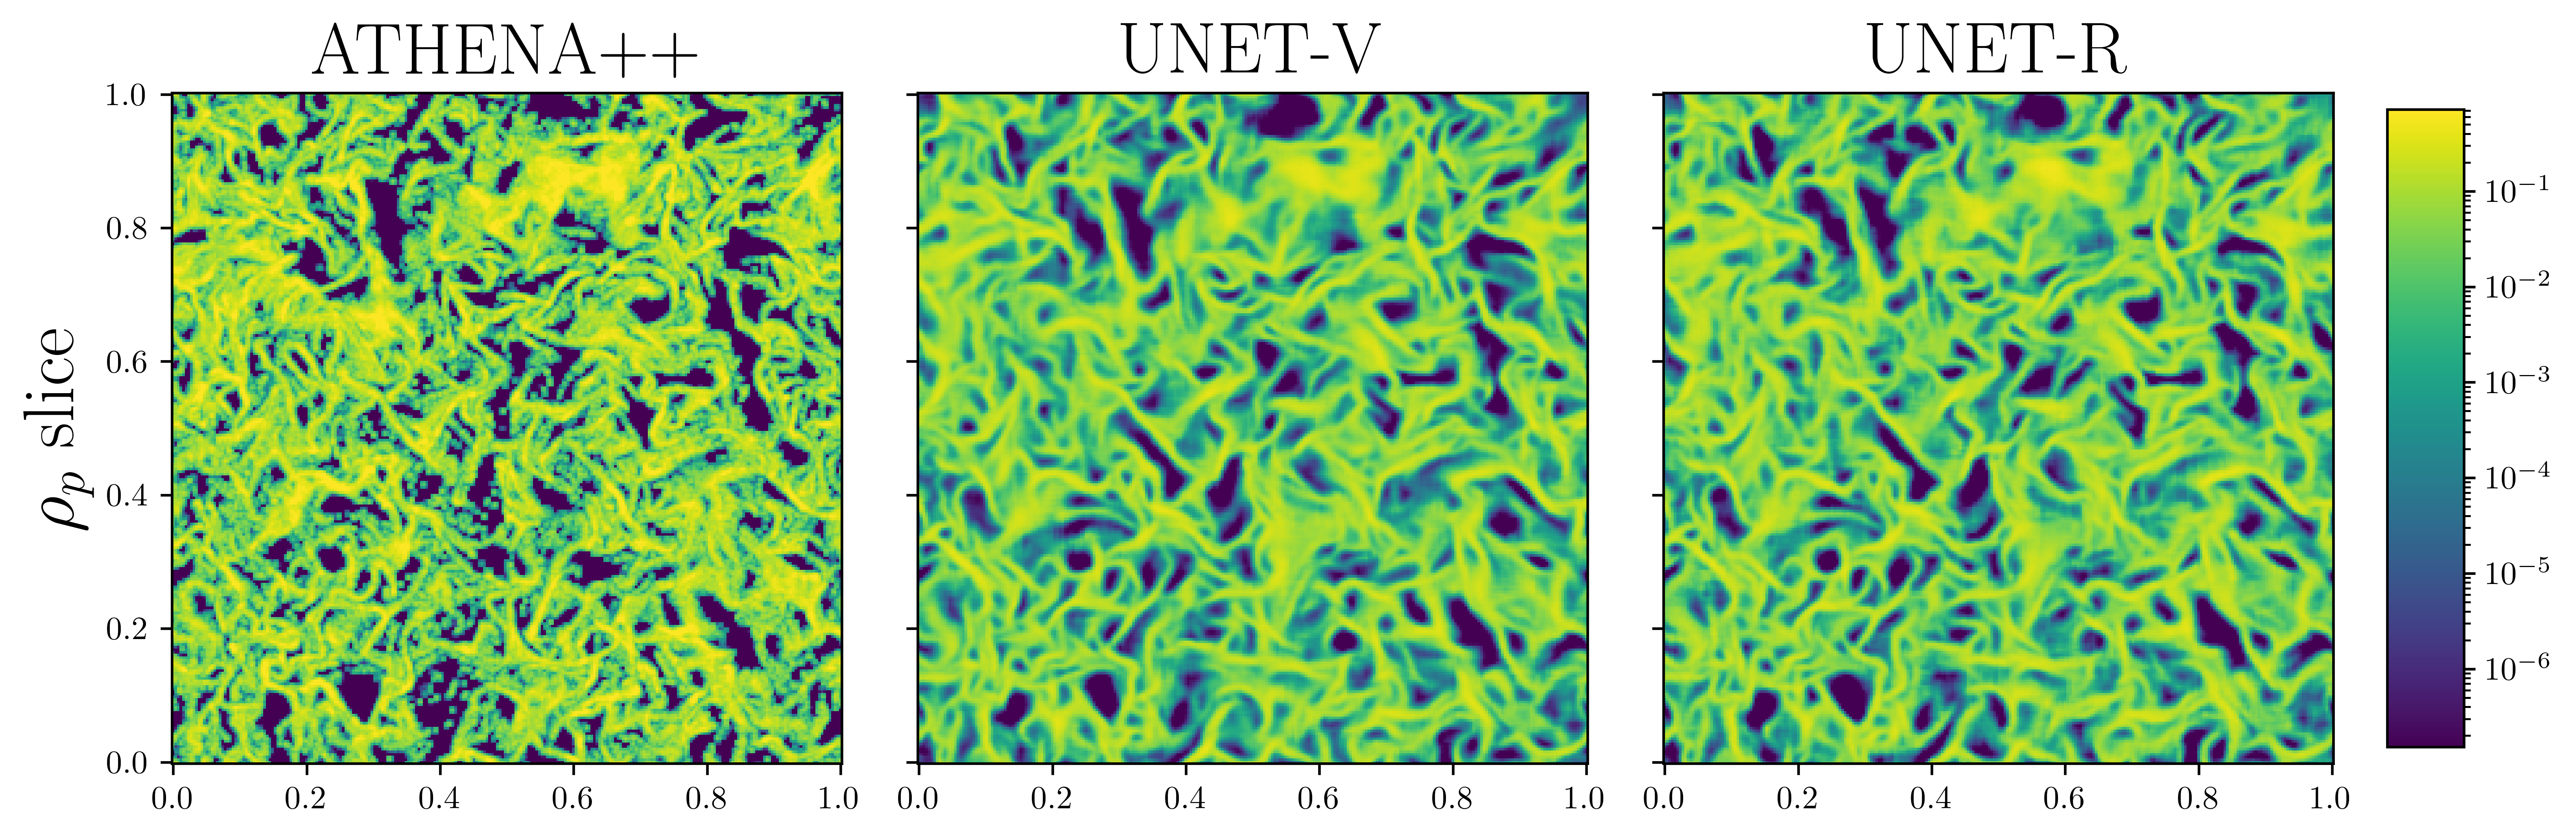

In [90]:
with PdfPages('rhop_slice_comp_normal.pdf') as pdf:
    fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(10.8,4.5),sharey='row',**plot_params)
    eps,ql,qh,_ = plot_slice(axs[0],tgt_rhop)
    _,_,_,_   = plot_slice(axs[1],unetv_rhop,ql=ql,qh=qh)
    _,_,_, im = plot_slice(axs[2],unetr_rhop,ql=ql,qh=qh)
    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    axs[0].set_title('ATHENA++',fontsize=22)
    axs[1].set_title('UNET-V',fontsize=22)
    axs[2].set_title('UNET-R',fontsize=22)
    axs[0].set_ylabel(r'$\rho_p$ slice',fontsize=22)
    fig.colorbar(im, ax=axs[2],shrink=0.6)
    pdf.savefig(fig)